## Data Overview

Compare summary stats for the overall VenEx data, the subset of data used in modeling, and the subset of data used for train/test split.

In [68]:
import sys
sys.path.append('../')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [69]:
from new_patient_model import extract_data_from_tables_new

## Load data

In [70]:
patient_data = pd.read_csv('../patient_data_venex/ven_responses_052023.txt', sep='\t')
patient_data.index = patient_data.Study_subject_Id

In [71]:
blood_counts = pd.read_excel('../patient_data_venex/Ven_blood_counts_16042023.xlsx', sheet_name='Blood_counts')
bm_blasts = pd.read_excel('../patient_data_venex/Ven_blood_counts_16042023.xlsx', sheet_name='Bone_marrow_blasts')
cycle_days = pd.read_excel('../patient_data_venex/Ven_blood_counts_16042023.xlsx', sheet_name='Cycle_days')

In [72]:
# load data on model assumptions/hypotheses
neut_blast_correlations = pd.read_csv('neut_blast_treatment_correlations_2025_05_09.csv', index_col=0)

In [73]:
rmse_data_combined = pd.read_csv('rmse_data_combined_table_2025_05_01.csv', index_col=0)

In [74]:
patient_cycle_train_table = pd.read_csv('patient_cycle_train_table.csv', index_col=0)
patient_cycle_test_table = pd.read_csv('patient_cycle_test_table.csv', index_col=0)
patient_cycle_additional_table = pd.read_csv('patient_cycle_additional_table.csv', index_col=0)

In [75]:
patient_data.columns

Index(['Study_subject_Id', 'incl_dg_for_tables', 'no_ven_therapy', 'prev_allo',
       'prev_hypomet_all', 'Gender', 'age_group_scr', 'ecog_scr', 'hb_scr',
       'leuk_scr', 'neut_all_scr', 'trom_scr', 'ld_scr', 'b_blasts_scr',
       'blasts_bm_scr', 'fab', 'del_5', 'del_5q', 'del_7', 'del_7q', 'del_17p',
       'complex', 'monosomal', 'HR_karyotype', 'karyotype_normal', 'NPM1',
       'FLT3_tkd', 'FLT3_itd', 'FLT3_rat', 'CEBPA', 'DNMT3A', 'IDH1', 'IDH2',
       'TET2', 'RUNX1', 'SRSF2', 'TP53', 'ASXL1', 'BCOR', 'CDKN2A', 'CREBBP',
       'CUX1', 'EP300', 'ETV6', 'EZH2', 'GATA2', 'KDM6A', 'NF1', 'RAD21',
       'SETD2', 'STAG2', 'XRSR2', 'BRAF', 'CALR', 'CBL', 'CSF3R', 'GATA1',
       'JAK2', 'KIT', 'KRAS', 'NRAS', 'MPL', 'PDGFRA', 'PHF6', 'PTPN11',
       'SETBP1', 'SF3B1', 'SMC1A', 'SMC3', 'U2AF1', 'WT1', 'c1_response',
       'c2_response', 'c3_response', 'best_response', 'mrd_neg', 'mrd_method',
       'relapse_occurred', 'eot_reason', 'eot_response', 'status',
       'OS_time_ve

In [76]:
patient_data.groupby('no_ven_therapy').agg('count')['Study_subject_Id']

no_ven_therapy
No     92
Yes    12
Name: Study_subject_Id, dtype: int64

In [77]:
patient_data.groupby('mrd_neg').agg('count')['Study_subject_Id']

mrd_neg
#NULL!           32
No               31
Not available    11
Yes              30
Name: Study_subject_Id, dtype: int64

## Calculate the number of observations for each patient

In [78]:
all_patient_observation_counts = {}
for patient_id in patient_data.index:
    cycle_info, leuk_table, blast_table = extract_data_from_tables_new(blood_counts,
                                                        bm_blasts, cycle_days, patient_id, use_neut=True)
    obs_counts = {}
    obs_counts['neut'] = len(leuk_table)
    obs_counts['blast'] = len(blast_table)
    obs_counts['cycle'] = len(cycle_info)
    obs_counts['neut_min'] = leuk_table.b_neut.min()
    obs_counts['neut_max'] = leuk_table.b_neut.max()
    obs_counts['neut_med'] = leuk_table.b_neut.median()
    obs_counts['neut_below_05'] = leuk_table.b_neut.min() < 0.5
    obs_counts['blast_min'] = blast_table.bm_blasts.min()
    obs_counts['blast_max'] = blast_table.bm_blasts.max()
    obs_counts['blast_med'] = blast_table.bm_blasts.median()
    obs_counts['blast_below_5'] = blast_table.bm_blasts.min() < 5
    all_patient_observation_counts[patient_id] = obs_counts

In [79]:
all_patient_observation_counts = pd.DataFrame(all_patient_observation_counts).T

## All patient data

Data for all patients

In [80]:
patient_data[['Gender', 'age_group_scr', 'status', 'relapse_occurred']].describe()

,Gender,age_group_scr,status,relapse_occurred
count,104,104,104,104
unique,2,2,2,2
top,Male,75 years or younger,Exitus,No
freq,61,71,72,62


In [81]:
patient_data[['OS_time_ven2_days', 'PFS_time_days']].describe()

,OS_time_ven2_days,PFS_time_days
count,104.000000,104.000000
mean,388.048077,259.278846
std,278.663084,273.556776
min,6.000000,1.000000
25%,133.000000,1.000000
50%,371.500000,180.000000
75%,577.500000,406.000000
max,1120.000000,1120.000000


In [82]:
patient_data.groupby('best_response').agg('count')['Study_subject_Id']

best_response
CR             43
CRh             2
CRi            14
MLFS           13
PR/SD/PD/RD    18
Name: Study_subject_Id, dtype: int64

In [83]:
patient_data.groupby('incl_dg_for_tables').agg('count')['Study_subject_Id']

incl_dg_for_tables
De novo / ND AML    48
R/R AML             39
sAML                17
Name: Study_subject_Id, dtype: int64

In [84]:
all_patient_observation_counts[['neut', 'blast', 'cycle']].astype(float).describe()

,neut,blast,cycle
count,104.000000,104.000000,104.000000
mean,17.605769,5.451923,8.653846
std,15.616408,3.398686,9.434258
min,1.000000,1.000000,0.000000
25%,6.000000,3.000000,2.000000
50%,12.500000,5.000000,5.000000
75%,23.000000,8.000000,13.250000
max,59.000000,14.000000,37.000000


In [85]:
all_patient_observation_counts[['neut_min', 'neut_max', 'neut_med', 'blast_min', 'blast_max', 'blast_med']].astype(float).describe()

,neut_min,neut_max,neut_med,blast_min,blast_max,blast_med
count,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000
mean,0.348712,3.324952,0.989380,11.745192,48.519231,18.579327
std,1.159769,3.018747,1.263982,19.833775,25.424448,22.828781
min,0.000000,0.010000,0.000000,2.500000,2.500000,2.500000
25%,0.000000,1.220500,0.317500,2.500000,29.750000,2.500000
50%,0.058000,2.478500,0.722500,2.500000,47.500000,7.000000
75%,0.200000,4.640000,1.100000,10.000000,72.000000,26.062500
max,10.680000,16.000000,10.680000,88.000000,94.000000,88.000000


In [86]:
all_patient_observation_counts[['neut_below_05', 'blast_below_5']].describe()

,neut_below_05,blast_below_5
count,104,104
unique,2,2
top,True,True
freq,89,75


## All ven/aza data

Data for all patients with some ven/aza treatment.

In [87]:
ven_patients = patient_data[patient_data.no_ven_therapy=='No'].index

In [88]:
print(len(ven_patients))

92


In [89]:
ven_patient_data = patient_data.loc[ven_patients]

In [90]:
ven_patient_data[['Gender', 'age_group_scr', 'status', 'relapse_occurred']].describe()

,Gender,age_group_scr,status,relapse_occurred
count,92,92,92,92
unique,2,2,2,2
top,Male,75 years or younger,Exitus,No
freq,53,61,61,50


In [91]:
ven_patient_data[['OS_time_ven2_days', 'PFS_time_days']].describe()

,OS_time_ven2_days,PFS_time_days
count,92.000000,92.000000
mean,415.565217,292.967391
std,274.854739,273.417985
min,6.000000,1.000000
25%,181.750000,85.000000
50%,395.000000,232.500000
75%,603.750000,432.750000
max,1120.000000,1120.000000


In [92]:
ven_patient_data.groupby('best_response').agg('count')['Study_subject_Id']

best_response
CR             43
CRh             2
CRi            14
MLFS           13
PR/SD/PD/RD    18
Name: Study_subject_Id, dtype: int64

In [93]:
ven_patient_data.groupby('incl_dg_for_tables').agg('count')['Study_subject_Id']

incl_dg_for_tables
De novo / ND AML    48
R/R AML             32
sAML                12
Name: Study_subject_Id, dtype: int64

In [94]:
all_patient_observation_counts[['neut', 'blast', 'cycle']].astype(float).loc[ven_patients].describe()

,neut,blast,cycle
count,92.000000,92.000000,92.000000
mean,19.695652,6.021739,9.782609
std,15.416374,3.196764,9.464597
min,3.000000,1.000000,1.000000
25%,8.000000,4.000000,3.000000
50%,14.500000,5.000000,5.500000
75%,29.750000,8.000000,15.250000
max,59.000000,14.000000,37.000000


In [95]:
all_patient_observation_counts[['neut_min', 'neut_max', 'neut_med', 'blast_min', 'blast_max', 'blast_med']].astype(float).loc[ven_patients].describe()

,neut_min,neut_max,neut_med,blast_min,blast_max,blast_med
count,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000
mean,0.143457,3.412489,0.855978,9.000000,50.434783,16.657609
std,0.364799,2.990093,0.804658,17.018251,24.832208,21.718311
min,0.000000,0.010000,0.000000,2.500000,2.500000,2.500000
25%,0.000000,1.270000,0.310000,2.500000,30.000000,2.500000
50%,0.040000,2.570000,0.677500,2.500000,50.000000,2.500000
75%,0.165000,4.720000,1.073750,2.500000,72.500000,21.375000
max,3.200000,16.000000,4.800000,86.000000,94.000000,86.000000


In [96]:
all_patient_observation_counts[['neut_below_05', 'blast_below_5']].loc[ven_patients].describe()

,neut_below_05,blast_below_5
count,92,92
unique,2,2
top,True,True
freq,86,74


## Modeling data

This includes all patients with enough data for ODE modeling (5 points)

In [97]:
modeling_patients = rmse_data_combined.index.unique()

In [98]:
print(len(modeling_patients))

71


In [99]:
modeling_patient_data = patient_data.loc[modeling_patients]

In [100]:
modeling_patient_data[['Gender', 'age_group_scr', 'status', 'relapse_occurred']].describe()

,Gender,age_group_scr,status,relapse_occurred
count,71,71,71,71
unique,2,2,2,2
top,Male,75 years or younger,Exitus,No
freq,40,47,41,36


In [101]:
modeling_patient_data[['OS_time_ven2_days', 'PFS_time_days']].describe()

,OS_time_ven2_days,PFS_time_days
count,71.000000,71.000000
mean,493.309859,370.239437
std,245.786992,264.784142
min,105.000000,1.000000
25%,290.500000,158.000000
50%,466.000000,329.000000
75%,653.500000,539.000000
max,1120.000000,1120.000000


In [102]:
modeling_patient_data.groupby('best_response').agg('count')['Study_subject_Id']

best_response
CR             41
CRh             1
CRi            14
MLFS            9
PR/SD/PD/RD     6
Name: Study_subject_Id, dtype: int64

In [103]:
modeling_patient_data.groupby('incl_dg_for_tables').agg('count')['Study_subject_Id']

incl_dg_for_tables
De novo / ND AML    40
R/R AML             22
sAML                 9
Name: Study_subject_Id, dtype: int64

In [104]:
all_patient_observation_counts[['neut', 'blast', 'cycle']].loc[modeling_patients].astype(float).describe()

,neut,blast,cycle
count,71.000000,71.000000,71.000000
mean,23.746479,6.957746,12.183099
std,15.286519,2.915165,9.527869
min,3.000000,2.000000,2.000000
25%,11.000000,5.000000,4.500000
50%,19.000000,6.000000,9.000000
75%,36.000000,8.000000,19.000000
max,59.000000,14.000000,37.000000


In [105]:
all_patient_observation_counts[['neut_min', 'neut_max', 'neut_med', 'blast_min', 'blast_max', 'blast_med']].astype(float).loc[ven_patients].describe()

,neut_min,neut_max,neut_med,blast_min,blast_max,blast_med
count,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000
mean,0.143457,3.412489,0.855978,9.000000,50.434783,16.657609
std,0.364799,2.990093,0.804658,17.018251,24.832208,21.718311
min,0.000000,0.010000,0.000000,2.500000,2.500000,2.500000
25%,0.000000,1.270000,0.310000,2.500000,30.000000,2.500000
50%,0.040000,2.570000,0.677500,2.500000,50.000000,2.500000
75%,0.165000,4.720000,1.073750,2.500000,72.500000,21.375000
max,3.200000,16.000000,4.800000,86.000000,94.000000,86.000000


In [106]:
all_patient_observation_counts[['neut_below_05', 'blast_below_5']].loc[ven_patients].describe()

,neut_below_05,blast_below_5
count,92,92
unique,2,2
top,True,True
freq,86,74


### Model assumptions/hypotheses

In [107]:
modeling_patient_data = modeling_patient_data.join(neut_blast_correlations)

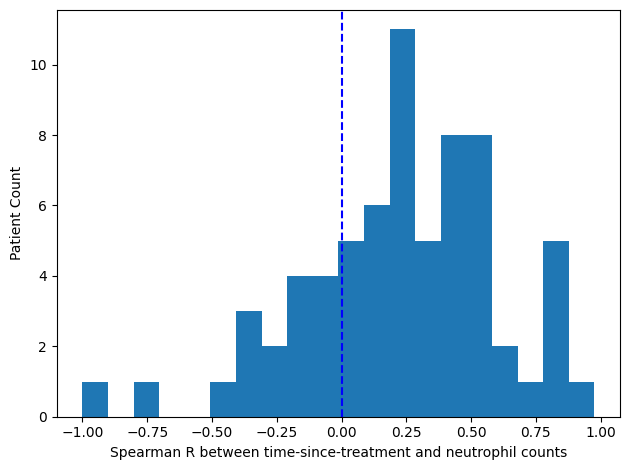

In [108]:
plt.hist(modeling_patient_data.neut_treatment_spearmanr, bins=20)
plt.axvline(0, color='blue', linestyle='--', label='zero')
#plt.title('Assumption 1')
plt.xlabel('Spearman R between time-since-treatment and neutrophil counts')
plt.ylabel('Patient Count')
plt.tight_layout()
plt.savefig('fig2b_h1.png', dpi=300)
plt.show()

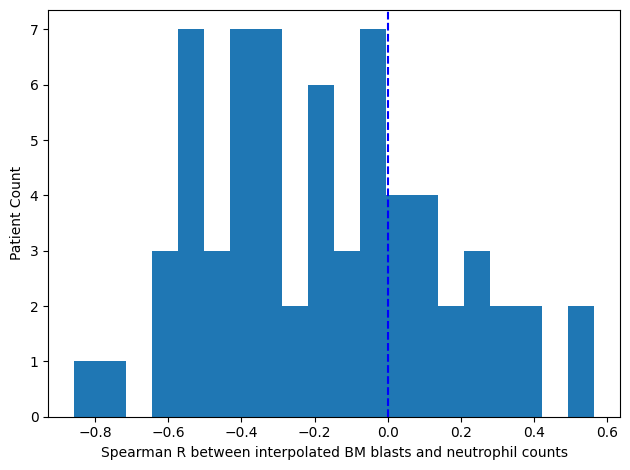

In [109]:
plt.hist(modeling_patient_data.neut_blast_spearmanr, bins=20)
plt.axvline(0, color='blue', linestyle='--', label='zero')
#plt.title('Assumption 2')
plt.xlabel('Spearman R between interpolated BM blasts and neutrophil counts')
plt.ylabel('Patient Count')
plt.tight_layout()
plt.savefig('fig2b_h2.png', dpi=300)
plt.show()

In [110]:
h1_subset = modeling_patient_data[~modeling_patient_data.neut_treatment_spearmanr.isna()]

In [111]:
positive_corr = sum(h1_subset.neut_treatment_spearmanr > 0)
negative_corr = sum(h1_subset.neut_treatment_spearmanr <= 0)
print('negative correlations: ', negative_corr/len(h1_subset), 'of patients')
print('positive correlations: ', positive_corr/len(h1_subset), 'of patients')

negative correlations:  0.2647058823529412 of patients
positive correlations:  0.7352941176470589 of patients


In [112]:
import scipy.stats
scipy.stats.binomtest(positive_corr, len(h1_subset))

BinomTestResult(k=50, n=68, alternative='two-sided', statistic=0.7352941176470589, pvalue=0.00013083876154198454)

In [113]:
h2_subset = modeling_patient_data[~modeling_patient_data.neut_blast_spearmanr.isna()]

In [114]:
positive_corr = sum(h2_subset.neut_blast_spearmanr >= 0)
negative_corr = sum(h2_subset.neut_blast_spearmanr < 0)
print('negative correlations: ', negative_corr/len(h2_subset), 'of patients')
print('positive correlations: ', positive_corr/len(h2_subset), 'of patients')

negative correlations:  0.7272727272727273 of patients
positive correlations:  0.2727272727272727 of patients


In [115]:
scipy.stats.binomtest(negative_corr, len(h2_subset))

BinomTestResult(k=48, n=66, alternative='two-sided', statistic=0.7272727272727273, pvalue=0.00028711844966164033)

### Test for Assumption 2 with no interpolation

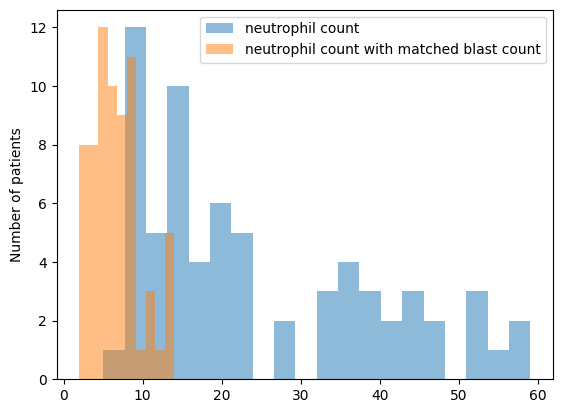

In [49]:
plt.hist(modeling_patient_data.neut_count, bins=20, alpha=0.5, label='neutrophil count')
plt.hist(modeling_patient_data.matched_neut_count, alpha=0.5, label='neutrophil count with matched blast count')
plt.legend()
plt.ylabel('Number of patients')
plt.show()

Because of the differences in numbers of samples, we should probably exclude the patients with too few matched samples.

Considering only patients with more than some number of matched samples...

In [54]:
min_samples = 5

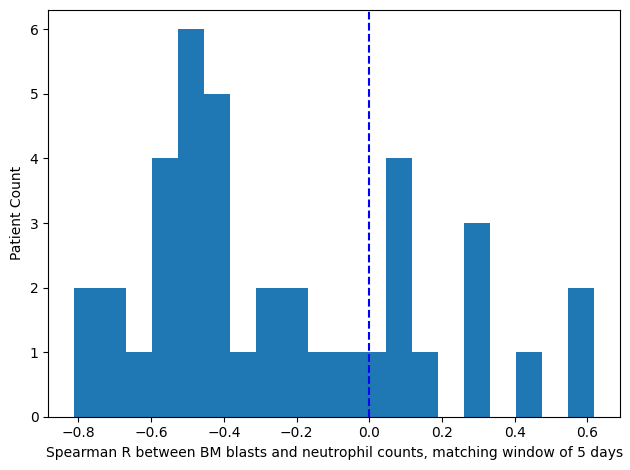

In [77]:
# Assumption 2 - no interp
plt.hist(modeling_patient_data.neut_blast_nointerp_spearmanr[modeling_patient_data.matched_neut_count>min_samples], bins=20)
plt.axvline(0, color='blue', linestyle='--', label='zero')
#plt.title('Assumption 2')
plt.xlabel('Spearman R between BM blasts and neutrophil counts, matching window of 5 days')
plt.ylabel('Patient Count')
plt.tight_layout()
plt.savefig('fig2b_h2_nointerp_5_window.png', dpi=300)
plt.show()

In [78]:
h2_subset = modeling_patient_data[(~modeling_patient_data.neut_blast_nointerp_spearmanr.isna()) & (modeling_patient_data.matched_neut_count > min_samples)]

In [79]:
len(h2_subset)

39

In [80]:
positive_corr = sum(h2_subset.neut_blast_nointerp_spearmanr >= 0)
negative_corr = sum(h2_subset.neut_blast_nointerp_spearmanr < 0)
print('negative correlations: ', negative_corr/len(h2_subset), 'of patients')
print('positive correlations: ', positive_corr/len(h2_subset), 'of patients')

negative correlations:  0.6923076923076923 of patients
positive correlations:  0.3076923076923077 of patients


In [81]:
scipy.stats.binomtest(negative_corr, len(h2_subset))

BinomTestResult(k=27, n=39, alternative='two-sided', statistic=0.6923076923076923, pvalue=0.023702702470473014)

In [82]:
h2_subset_5_days = h2_subset

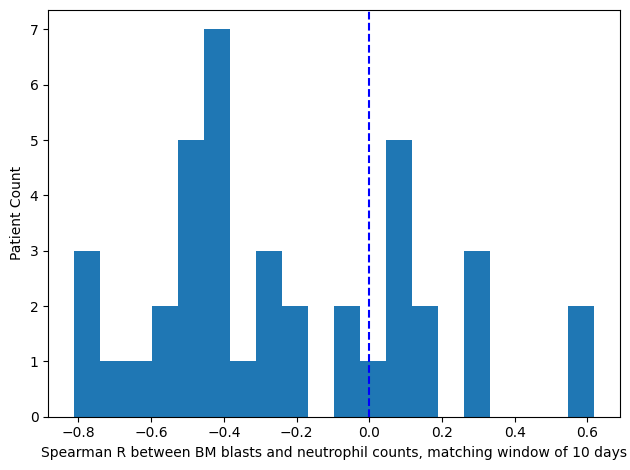

In [83]:
# Assumption 2 - no interp, 10 window
plt.hist(modeling_patient_data.neut_blast_nointerp_spearmanr_10_window[modeling_patient_data.matched_neut_count_10_window>min_samples], bins=20)
plt.axvline(0, color='blue', linestyle='--', label='zero')
#plt.title('Assumption 2')
plt.xlabel('Spearman R between BM blasts and neutrophil counts, matching window of 10 days')
plt.ylabel('Patient Count')
plt.tight_layout()
plt.savefig('fig2b_h2_nointerp_10_window.png', dpi=300)
plt.show()

In [84]:
h2_subset = modeling_patient_data[(~modeling_patient_data.neut_blast_nointerp_spearmanr_10_window.isna()) & (modeling_patient_data.matched_neut_count_10_window > min_samples)]

In [85]:
len(h2_subset)

40

In [86]:
positive_corr = sum(h2_subset.neut_blast_nointerp_spearmanr_10_window >= 0)
negative_corr = sum(h2_subset.neut_blast_nointerp_spearmanr_10_window < 0)
print('negative correlations: ', negative_corr/len(h2_subset), 'of patients')
print('positive correlations: ', positive_corr/len(h2_subset), 'of patients')

negative correlations:  0.7 of patients
positive correlations:  0.3 of patients


In [87]:
scipy.stats.binomtest(negative_corr, len(h2_subset))

BinomTestResult(k=28, n=40, alternative='two-sided', statistic=0.7, pvalue=0.01658900337497471)

In [88]:
h2_subset_10_days = h2_subset

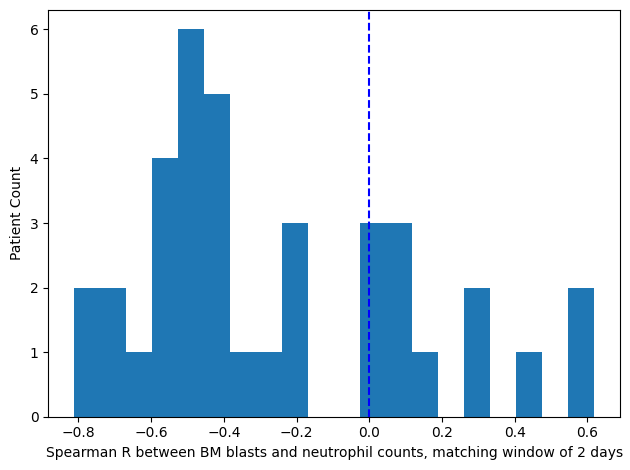

In [89]:
# Assumption 2 - no interp, 10 window
plt.hist(modeling_patient_data.neut_blast_nointerp_spearmanr_2_window[modeling_patient_data.matched_neut_count_2_window>min_samples], bins=20)
plt.axvline(0, color='blue', linestyle='--', label='zero')
#plt.title('Assumption 2')
plt.xlabel('Spearman R between BM blasts and neutrophil counts, matching window of 2 days')
plt.ylabel('Patient Count')
plt.tight_layout()
plt.savefig('fig2b_h2_nointerp_2_window.png', dpi=300)
plt.show()

In [90]:
h2_subset = modeling_patient_data[(~modeling_patient_data.neut_blast_nointerp_spearmanr_2_window.isna()) & (modeling_patient_data.matched_neut_count_2_window > min_samples)]

In [91]:
len(h2_subset)

37

In [92]:
positive_corr = sum(h2_subset.neut_blast_nointerp_spearmanr_2_window >= 0)
negative_corr = sum(h2_subset.neut_blast_nointerp_spearmanr_2_window < 0)
print('negative correlations: ', negative_corr/len(h2_subset), 'of patients')
print('positive correlations: ', positive_corr/len(h2_subset), 'of patients')

negative correlations:  0.6756756756756757 of patients
positive correlations:  0.32432432432432434 of patients


In [93]:
scipy.stats.binomtest(negative_corr, len(h2_subset))

BinomTestResult(k=25, n=37, alternative='two-sided', statistic=0.6756756756756757, pvalue=0.04703102743951604)

In [94]:
h2_subset_2_days = h2_subset

In [99]:
window_10 = h2_subset_10_days[h2_subset_10_days.neut_blast_nointerp_spearmanr_10_window < 0]
window_5 = h2_subset_5_days[h2_subset_5_days.neut_blast_nointerp_spearmanr < 0]
window_2 = h2_subset_2_days[h2_subset_5_days.neut_blast_nointerp_spearmanr_2_window < 0]
interp = h2_subset[h2_subset.neut_blast_spearmanr < 0]

/tmp/ipykernel_979/1769629355.py:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [115]:
window_10_false = h2_subset_10_days[h2_subset_10_days.neut_blast_nointerp_spearmanr_10_window >= 0]
window_5_false = h2_subset_5_days[h2_subset_5_days.neut_blast_nointerp_spearmanr >= 0]
window_2_false = h2_subset_2_days[h2_subset_5_days.neut_blast_nointerp_spearmanr_2_window >= 0]
interp_false = h2_subset[h2_subset.neut_blast_spearmanr >= 0]

/tmp/ipykernel_979/3791835618.py:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [104]:
len(window_10)

28

In [106]:
len(window_5)

27

In [107]:
len(window_2)

25

In [108]:
len(interp)

48

In [103]:
len(set(window_10.index).intersection(window_5.index))

26

In [105]:
len(set(window_10.index).intersection(window_2.index))

24

In [109]:
len(set(window_10.index).intersection(interp.index))

27

In [ ]:
len(set(window_10.index).intersection(interp.index))

In [110]:
import matplotlib_venn

/home/yzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/matplotlib_venn/_venn3.py:117: UserWarning:

Bad circle positioning



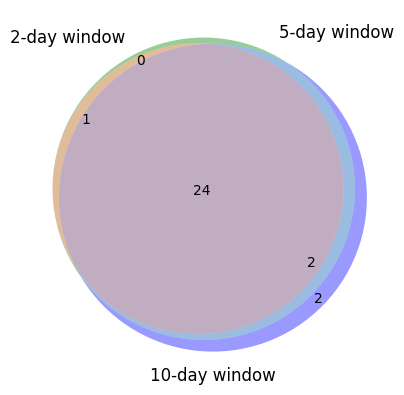

In [111]:
matplotlib_venn.venn3([set(window_2.index), set(window_5.index), set(window_10.index)], ['2-day window', '5-day window', '10-day window'])

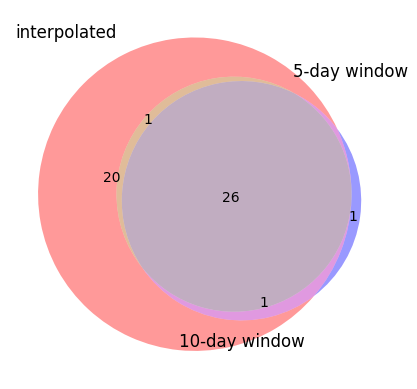

In [113]:
matplotlib_venn.venn3([set(interp.index), set(window_5.index), set(window_10.index)], ['interpolated', '5-day window', '10-day window'])

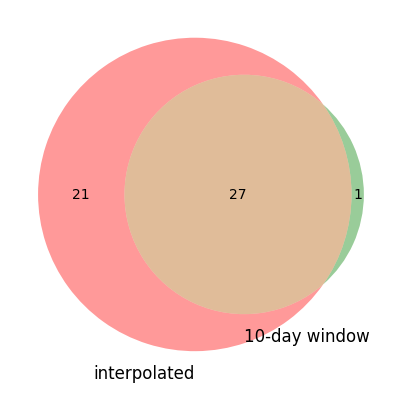

In [114]:
matplotlib_venn.venn2([set(interp.index), set(window_10.index)], ['interpolated', '10-day window'])

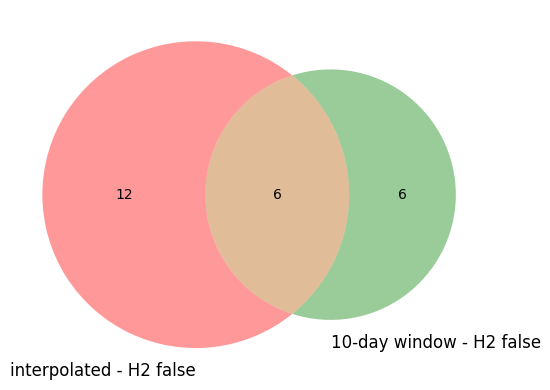

In [118]:
matplotlib_venn.venn2([set(interp_false.index), set(window_10_false.index)], ['interpolated - H2 false', '10-day window - H2 false'])

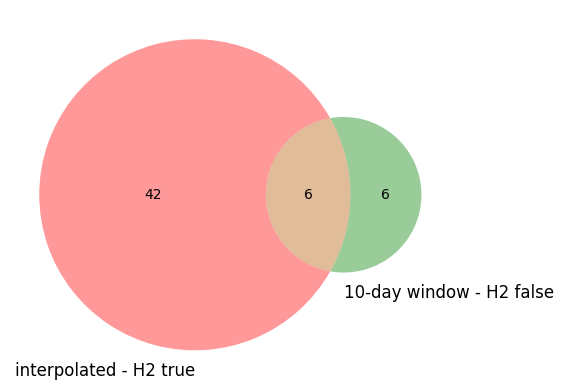

In [119]:
matplotlib_venn.venn2([set(interp.index), set(window_10_false.index)], ['interpolated - H2 true', '10-day window - H2 false'])

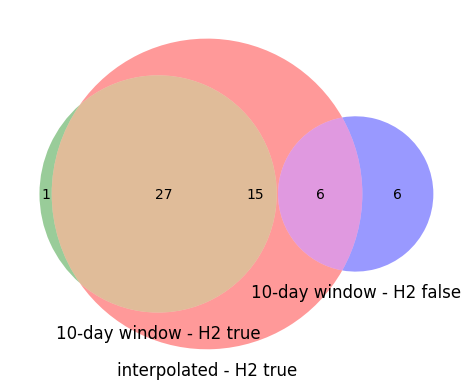

In [120]:
matplotlib_venn.venn3([set(interp.index), set(window_10.index), set(window_10_false.index)],
                      ['interpolated - H2 true', '10-day window - H2 true', '10-day window - H2 false'])

## Train/test data

This includes all patients with enough data for the train/test split.

In [116]:
train_test_patients = patient_cycle_train_table.index.unique()

In [117]:
print(len(train_test_patients))

33


In [118]:
train_test_patient_data = patient_data.loc[train_test_patients]

In [119]:
train_test_patient_data[['Gender', 'age_group_scr', 'status', 'relapse_occurred']].describe()

,Gender,age_group_scr,status,relapse_occurred
count,33,33,33,33
unique,2,2,2,2
top,Male,75 years or younger,Alive,No
freq,20,22,20,19


In [120]:
train_test_patient_data[['OS_time_ven2_days', 'PFS_time_days']].describe()

,OS_time_ven2_days,PFS_time_days
count,33.000000,33.00000
mean,614.636364,534.30303
std,223.354793,246.73651
min,249.000000,215.00000
25%,442.000000,344.00000
50%,585.000000,533.00000
75%,702.000000,673.00000
max,1120.000000,1120.00000


In [121]:
train_test_patient_data.groupby('best_response').agg('count')['Study_subject_Id']

best_response
CR      24
CRi      8
MLFS     1
Name: Study_subject_Id, dtype: int64

In [122]:
train_test_patient_data.groupby('incl_dg_for_tables').agg('count')['Study_subject_Id']

incl_dg_for_tables
De novo / ND AML    25
R/R AML              6
sAML                 2
Name: Study_subject_Id, dtype: int64

In [123]:
all_patient_observation_counts[['neut', 'blast', 'cycle']].loc[train_test_patients].astype(float).describe()

,neut,blast,cycle
count,33.000000,33.000000,33.000000
mean,33.090909,8.424242,18.181818
std,14.725326,2.872611,9.254913
min,11.000000,4.000000,7.000000
25%,19.000000,6.000000,10.000000
50%,33.000000,8.000000,16.000000
75%,45.000000,10.000000,25.000000
max,59.000000,14.000000,37.000000


In [124]:
all_patient_observation_counts[['neut_min', 'neut_max', 'neut_med', 'blast_min', 'blast_max', 'blast_med']].astype(float).loc[train_test_patients].describe()

,neut_min,neut_max,neut_med,blast_min,blast_max,blast_med
count,33.000000,33.000000,33.000000,33.0,33.000000,33.000000
mean,0.141364,4.107909,1.038606,2.5,46.272727,3.916667
std,0.159104,2.535089,0.649184,0.0,25.081458,3.348663
min,0.000000,1.260000,0.130000,2.5,9.000000,2.500000
25%,0.000000,2.400000,0.645000,2.5,30.000000,2.500000
50%,0.092000,3.100000,0.858000,2.5,35.000000,2.500000
75%,0.190000,5.050000,1.300000,2.5,72.000000,2.500000
max,0.570000,11.060000,2.925000,2.5,85.000000,14.000000


In [125]:
all_patient_observation_counts[['neut_below_05', 'blast_below_5']].loc[train_test_patients].describe()

,neut_below_05,blast_below_5
count,33,33
unique,2,1
top,True,True
freq,31,33


### Model assumptions/hypotheses

In [126]:
train_test_patient_data = train_test_patient_data.join(neut_blast_correlations)

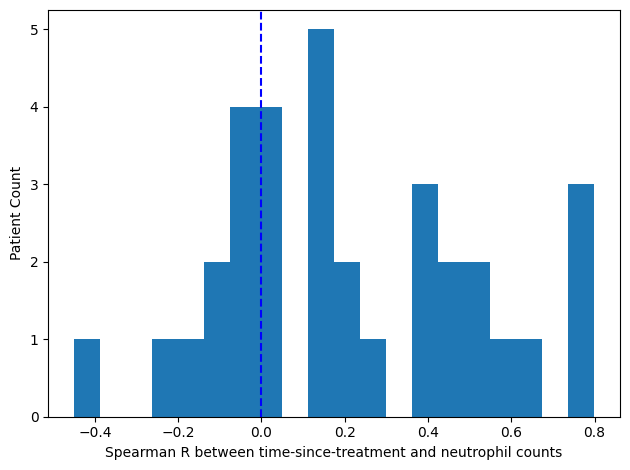

In [135]:
plt.hist(train_test_patient_data.neut_treatment_spearmanr, bins=20)
plt.axvline(0, color='blue', linestyle='--', label='zero')
#plt.title('Assumption 1')
plt.xlabel('Spearman R between time-since-treatment and neutrophil counts')
plt.ylabel('Patient Count')
plt.tight_layout()
#plt.savefig('fig2b_h1.png', dpi=300)
plt.show()

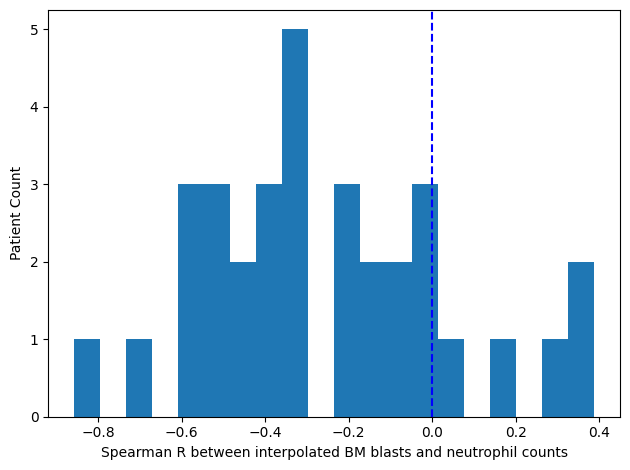

In [136]:
plt.hist(train_test_patient_data.neut_blast_spearmanr, bins=20)
plt.axvline(0, color='blue', linestyle='--', label='zero')
#plt.title('Assumption 2')
plt.xlabel('Spearman R between interpolated BM blasts and neutrophil counts')
plt.ylabel('Patient Count')
plt.tight_layout()
#plt.savefig('fig2b_h2.png', dpi=300)
plt.show()

In [129]:
h1_subset = train_test_patient_data[~train_test_patient_data.neut_treatment_spearmanr.isna()]

In [130]:
positive_corr = sum(h1_subset.neut_treatment_spearmanr > 0)
negative_corr = sum(h1_subset.neut_treatment_spearmanr <= 0)
print('negative correlations: ', negative_corr/len(h1_subset), 'of patients')
print('positive correlations: ', positive_corr/len(h1_subset), 'of patients')

negative correlations:  0.3333333333333333 of patients
positive correlations:  0.6666666666666666 of patients


In [131]:
import scipy.stats
scipy.stats.binomtest(positive_corr, len(h1_subset))

BinomTestResult(k=22, n=33, alternative='two-sided', statistic=0.6666666666666666, pvalue=0.08014331245794892)

In [132]:
h2_subset = modeling_patient_data[~modeling_patient_data.neut_blast_spearmanr.isna()]

In [133]:
positive_corr = sum(h2_subset.neut_blast_spearmanr >= 0)
negative_corr = sum(h2_subset.neut_blast_spearmanr < 0)
print('negative correlations: ', negative_corr/len(h2_subset), 'of patients')
print('positive correlations: ', positive_corr/len(h2_subset), 'of patients')

negative correlations:  0.7272727272727273 of patients
positive correlations:  0.2727272727272727 of patients


In [134]:
scipy.stats.binomtest(negative_corr, len(h2_subset))

BinomTestResult(k=48, n=66, alternative='two-sided', statistic=0.7272727272727273, pvalue=0.00028711844966164033)